In [10]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)  
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 50)

# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

**Пути к директориям и папкам**

In [5]:
TRAIN_DATASET_PATH = 'train.csv'

# Загрузка данных

**Описание датасета**

В датасете представлены данные о пассажирах Титаника, их возраст, пол и другие характеристики:


0- passengerID: passenger id.

1- survival: Survival 0 = No, 1 = Yes.

2- pclass: Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd.

3- sex: Sex.

4- Age: Age in years.

5- sibsp: # of siblings / spouses aboard the Titanic.

6- parch: # of parents / children aboard the Titanic.

7- ticket: Ticket number.

8- fare: Passenger fare.

9- cabin: Cabin number.

10- embarked: Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton.

**Вопросы для анализа:**

* **1:** Влияет ли возраст на выживаемость пассажиров?
* **2:** Влияет ли пол пассажира на выживаемость?
* **3:** Влияет ли стоимость билета на выживаемость пассажира?
* **4:** Влиет ли класс каюты пассажира на выживаемость?
* **5:** Влиет ли наличие братьев/сестер или супруга/жены на рейсе на выживаемость пассажира?
* **6:** Влиет ли наличие детей или родителей на выживаемость пассажира?
* **7:** Влиет ли порт посадки на рейс на выживаемость пассажира?


# Предварительный анализ
**Для начала посмотрим на данные**

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, index_col='PassengerId')
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,0,PC 17599,71.28,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


In [15]:
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,714.00,891.00,891.00,891.00
mean,0.38,2.31,29.70,0.52,0.38,32.20
std,0.49,0.84,14.53,1.10,0.81,49.69
min,0.00,1.00,0.42,0.00,0.00,0.00
25%,0.00,2.00,20.12,0.00,0.00,7.91
50%,0.00,3.00,28.00,0.00,0.00,14.45
75%,1.00,3.00,38.00,1.00,0.00,31.00
max,1.00,3.00,80.00,8.00,6.00,512.33


In [45]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [8]:
train_df.shape

(891, 11)

**Выводы после первого просмотра**

Целевым значением будет значение "Survived" (Выжил)

* Всего пассажиров 891  
* Много пропущенных значений в "Age" (Возраст пассажира) (есть 714 из 891, % потерь 19.86) **заполним пропущенные значения средним**  
* Практически отсутсвуют значения в "Cabin" (Номер каюты) (есть 204 из 891, % потерь 77.10) **удалим**   
* "Name" (имя пассажира) известное имя или популярность пассажира могла повлиять на его выживаемость, но в формате данного анализа рассмотрение такого влияния не предоставляется возможным, поэтому **столбец придётся удалить**, как и "Ticket" (номер билета) и "PassengerID" (айди пассажира), значения которых скорее просто номинально-отчетные


# Приступим к очистке данных

Удалим "Name", "Ticket" и "Cabin"

In [16]:
train_df.drop(columns=["Name", "Ticket", "Cabin"], axis=1, inplace=True, errors='ignore')

Проверим результат

In [17]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.00,1,0,7.25,S
2,1,1,female,38.00,1,0,71.28,C
3,1,3,female,26.00,0,0,7.92,S
4,1,1,female,35.00,1,0,53.10,S
5,0,3,male,35.00,0,0,8.05,S


# Заполним пропущенные значения

**Age**

Заполним по медиане

In [13]:
age_mean = train_df['Age'].mean()
print(age_mean)
train_df['Age'].fillna(age_mean, inplace=True)

29.69911764705882


Проверим результат

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.6+ KB


**Embarked**

Так как это категориальный признак, сначала рассмотрим какие значения присутсвуют

In [15]:
train_df["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Заполним по наиболее встречающемуся значению - "S"

In [31]:
train_df["Embarked"].fillna("S", inplace=True)

Проверим результат

In [32]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.6+ KB


**Пропущенных значений больше нет**

# Приступим к анализу данных

male      577
female    314
Name: Sex, dtype: int64


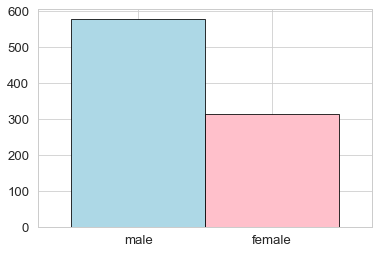

In [29]:
#Сначала посчитаем и визуализируем количество мужчин и женщин на судне
print(train_df["Sex"].value_counts())
train_df["Sex"].value_counts().plot.bar(edgecolor='black', rot=0, width=1, color=['lightblue', 'pink']);

**Количество женщин на судне меньше, чем мужчин**

In [37]:
#создадим интерпретацию для пассажиров, кто выжил и нет
survived = train_df['Survived'] == 1
died = train_df['Survived'] == 0

**Так как графиков будет много, то удобнее всего будет написать несколько функций для постройки графика по заданному параметру**

In [127]:
# Определим функцию для постройки графика, показывающего частоту повторения переменной на основе "Survived"
def plot_hist(col):
    #размер графика
    plt.figure(figsize=(7,7))
    #график
    train_df[col][survived].hist(alpha=0.6, color=['orange'], label='survided')
    train_df[col][died].hist(alpha=0.6, color=['lightblue'], label='died')
    #обозначения осей
    plt.ylabel('Frequency'.title(), fontsize = 14, weight = "bold")
    plt.xlabel('{}'.format(col).title(), fontsize = 14, weight = "bold") 
    #заголовок графика
    plt.title("frequency of people that survived and those who died depending on {}".format(col).title(), fontsize = 14, weight = "bold")
    #легенда
    plt.legend();

In [103]:
# Определим функцию для постойки графика, показывающего процент выживщих по переменной 
def bar_chart(column):
    #вывод долей
    print(train_df.groupby(column)['Survived'].value_counts(normalize=True).unstack(column))
    #параметры графика
    train_df.groupby(column)['Survived'].value_counts(normalize=True).unstack(column).plot.bar(edgecolor='black', figsize=[7, 7], rot=0, width=1, color=['pink', 'lightblue', 'orange'])
    #заголовок графика
    plt.title('{} and survival'.format(column).title(), fontsize = 14, weight = "bold")
    #обозначения осей
    plt.ylabel('percentage'.title(), fontsize = 14, weight = "bold")
    plt.xlabel('{}'.format('survived').title(), fontsize = 14, weight = "bold") ;

In [102]:
# defining a bar plot function to show the frequency of survival depending on a variable.
def bar_plot(col):
    
    print(train_df.groupby(col)['Survived'].value_counts(normalize=True).unstack(col))
    #легенда
    train_df[col][survived].value_counts().plot.bar(alpha=0.4, figsize=[7, 7], color=['blue'], label='survided')
    train_df[col][died].value_counts().plot.bar(alpha=0.7, figsize=[7, 7], color=['orange'], label='died')
    plt.xticks(rotation=0)
    #заголовок графика
    plt.title('{} and survival'.format(col).title(), fontsize = 14, weight = "bold")
    #обозначения осей
    plt.ylabel('frequency'.title(), fontsize = 14, weight = "bold")
    plt.xlabel('{}'.format('Survived').title(), fontsize = 14, weight = "bold") ;
    plt.legend();

# Вопрос 1:  Влияет ли возраст на выживаемость пассажиров?


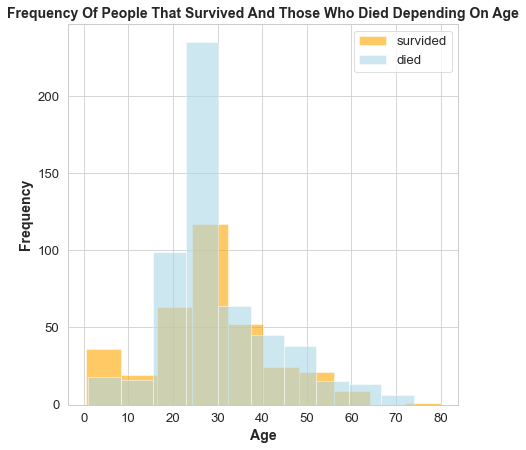

In [128]:
#построим график для возраста пассажира
plot_hist("Age")

**Вывод:** На основе графика видно, что наибольшее количество погибщих было в категории 20-30 лет. В то же время у детей и подростков (0-20 лет), а так же пожилых шансов выжить было больше.

# Вопрос 2:  Влияет ли пол пассажира на выживаемость?

Sex       female  male
Survived              
0           0.26  0.81
1           0.74  0.19


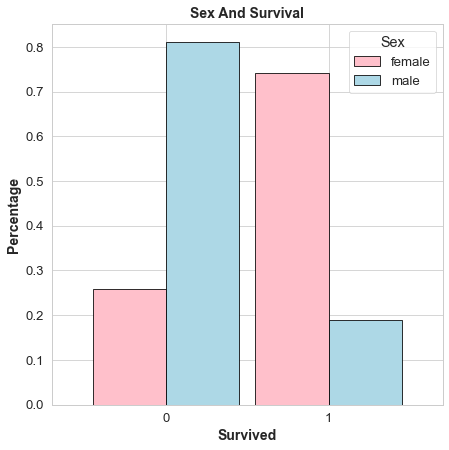

In [75]:
#построим график для пола пассажира
bar_chart("Sex")

**Вывод:** Из графика видно, что средний шанс выжить у мужчин был всего 20%, в то время как у женщин он в районе 75%. Предположение о том, что мужчны уступали места детям и женщинам.

# Вопрос 3:  Влияет ли стоимость билета на выживаемость пассажира??

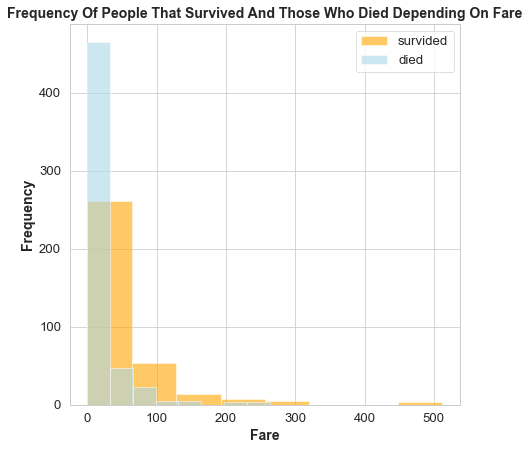

In [125]:
#построим график для стоимости билета
plot_hist("Fare")

In [83]:
#выведем медиану цены билета выживших и нет пассажиров
print("the mean fare of people who survived is {} dollar".format(train_df.Fare[survived].mean()))
print("the mean fare of people who died is {} dollar".format(train_df.Fare[died].mean()))

the mean fare of people who survived is 48.39540760233917 dollar
the mean fare of people who died is 22.117886885245877 dollar


**Вывод:** На основе графика и вычислений выше, можно сделать вывод, что с ценой билета менее медианы в 22.1$, пассажир был обречён (самые дешевые билеты были в каютах глубоко в трюме без окон и множеством узких коридоров, а так же толкучка в них не позволила пассажирам даже выбраться на поверность).

# Вопрос 4:  Влияет ли класс каюты пассажира на выживаемость?

Pclass      1    2    3
Survived               
0        0.37 0.53 0.76
1        0.63 0.47 0.24


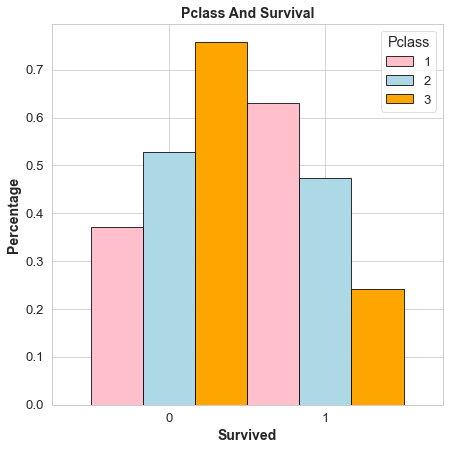

In [97]:
#построим график для классов кают
bar_chart("Pclass")

**Вывод:** Из графика видно, что наибольшие шансы на выживание были у пассажиров 1го класса и самые низкие у пассажиров 3го класса, что подтверждает вывод анализа стоимости билетов.

# Вопрос 5:  Влияет ли наличие братьев/сестер или супруга/жены на рейсе на выживаемость пассажира?

SibSp       0    1    2    3    4    5    8
Survived                                   
0        0.65 0.46 0.54 0.75 0.83 1.00 1.00
1        0.35 0.54 0.46 0.25 0.17  NaN  NaN


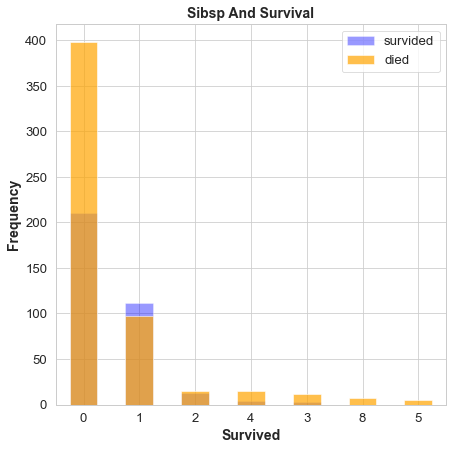

In [129]:
#посчитаем шансы выживаемости
bar_plot("SibSp")

**Вывод:** Пассажиры с 5 и более братьями и сёстрами вообще не имели шансов выжить, 54% шанс выжить был у тех, кто оказался в паре, пассажири в одиночестве имели всего 35% выживаемости.

# Вопрос 6:  Влияет ли наличие детей или родителей на выживаемость пассажира?

Parch       0    1    2    3    4    5    6
Survived                                   
0        0.66 0.45 0.50 0.40 1.00 0.80 1.00
1        0.34 0.55 0.50 0.60  NaN 0.20  NaN


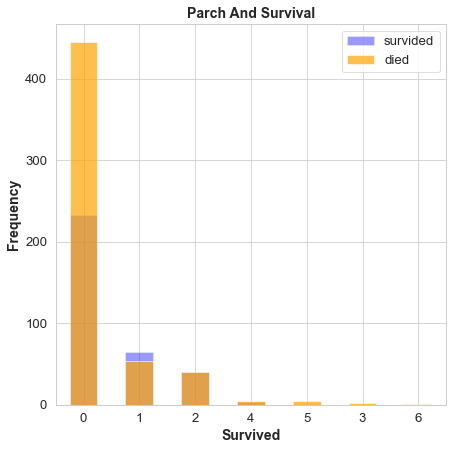

In [107]:
#построим график для пассажиров с детьми и родителями
bar_plot("Parch")

In [95]:
train_df.query('Parch == 5')

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
14,0,3,male,39.00,1,5,31.27,S
26,1,3,female,38.00,1,5,31.39,S
611,0,3,female,39.00,1,5,31.27,S
639,0,3,female,41.00,0,5,39.69,S
886,0,3,female,39.00,0,5,29.12,Q


**Вывод:** Только один пассажир с 5-ю детьми смог выжить, наивысшие шансы выжить имели пассажиры с 3-мя детьми - 60%, одиночки же имели 66% не выжить.

# Вопрос 7:  Влияет ли посадки на рейс на выживаемость пассажира?

Embarked    C    Q    S
Survived               
0        0.45 0.61 0.66
1        0.55 0.39 0.34


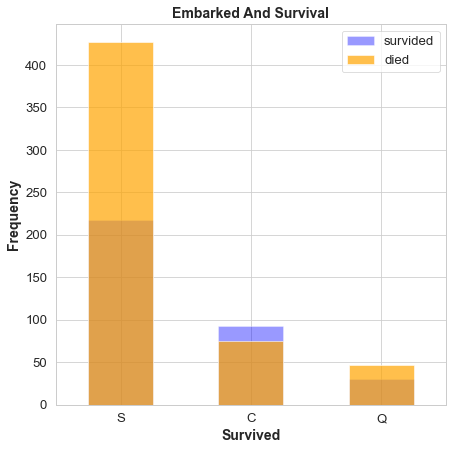

In [108]:
#построим график для порта посадки
bar_plot("Embarked")

**Вывод:** Из графика видно, что пассажиры попавшие на рейс с порта "C" (порт Cherbourg) имели 55% выжить

# Подведение итогов анализа

**1)** Пассажиров мужчим на рейсе было больше, чем женщин.  
**2)** Большинство пассажиров 20-30 лет имели крайне низкие шансы выжить, в то время как дети, подростки и пожилые имели высокие шансы.  
**3)** Женщины на судне имели 75% шанс на спасение, в то время как 80% мужчин погибли.  
**4)** Медианная цена билета выжившего составила 48.3$, в то время как погибшего - 22.1$.  
**5)** Самые высокие шансы выжить имели пассажиры 1го класса, в то время как среди пассажиров 3го класса спасся только каждый третий.  
**6)** Выживших с большим количеством братьев/сёстер (больше 4-х) нет, наибольшие шансы выжить были у пар, а наименьшие у одиночек - 35%.  
**7)** Только один пассажир с 5-ю детьми смог выжить, наивысшие шансы выжить имели пассажиры с 3-мя детьми - 60%, одиночки же имели 66% не выжить.  
**8)** Наибольшие шансы выжить были у пассажиров, попавших на рейс с порта "C" (порт Cherbourg) и имели 55% выжить.  

# Дополнения по улучшению анализа

**1)** Определённые данные, например, расстояние от каюты до выхода, конкретное место (верхнее или нижнее в каютах 3-го класса), билеты на концерт и прочие данные могли бы дополнить и уточнить анализ.  
**2)** Заполнение пропущенных значений другими способами